# Titanic Dataset  - ML Classification Model

## Intro

The following notebook is based on one of the most popular _Kaggle_ data sets, which refers to Titanic disaster. Dataset contains information about individual passengers, e.g. whether the passenger survived, what class he travelled, where he started his journey etc. Based on it I prepared ML classification model to predict if the passenger given in the test dataset survived or not.

- passenger survived (1)
- passenger died (0)

It is an example of supervised learning. The raw dataset comes from https://www.kaggle.com/c/titanic. It is divided into two subsets: 
- train - data for model training (passenger status is known)
- test - data for predictions (we do not know whether passenger survived, we need to predict that using ML model)

#### Columns:

    Survived  -  Survival (0 = No, 1 = Yes)
    Pclass  -  Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
    Name - name, surename, title
    Sex  -  gender
    Age  -  Age in years
    SibSp  -  Number of siblings / spouses aboard the Titanic
    Parch  -  Number of parents / children aboard the Titanic
    Ticket  -  Ticket number
    Fare  -  Passenger fare (price)
    Cabin  -  Cabin number
    Embarked  -  Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

#### Overview:
1. Environment Configuration

2. Data Exploration - data structure analysis, visualizations, possible correlations

3. Feature Engineering & Data Cleaning - data preprocessing (features, scalling, normalization, missing values etc.)

4. Model Building: K-Fold Cross Validation - ML model building based on classification algorithms and cross validation; model evaluation

5. Parameters tuning - selection of model hyperparameters

6. Test Dataset Prediction - prediction for test dataset

7. Results Export - export of results, model pickle

## 1. Environment Configuration

In [1]:
# Basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('precision', 2)
%matplotlib inline

DIR = '.'
EXT = '.csv'

# Results location
RES_PATH = os.path.join(DIR, "Results")

# Function saves generated results to .csv file
def save_res(var, name, extension=EXT):
    os.makedirs(RES_PATH, exist_ok=True)
    file_path = os.path.join(RES_PATH, name + extension)
    var.to_csv(file_path)

## 2. Data Exploration
#### Data loading into DataFrames:

In [3]:
# training dataset
X_full = pd.read_csv('./Titanic_dataset/train.csv', index_col='PassengerId')

# test dataset
X_test_full = pd.read_csv('./Titanic_dataset/test.csv', index_col='PassengerId')

# list of both datasets
both_datasets = [X_full, X_test_full]

#### A glance on the data structure in both datasets:

In [4]:
X_full.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


In [5]:
X_test_full.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.83,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.00,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.69,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.66,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.29,NaN,S


In [6]:
print("Training dataset columns:")
print(X_full.shape)
print(X_full.columns.values)
print("\nTest dataset columns:")
print(X_test_full.shape)
print(X_test_full.columns.values)

Training dataset columns:
(891, 11)
['Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']

Test dataset columns:
(418, 10)
['Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare' 'Cabin'
 'Embarked']


#### Comment:
Training dataset consists of only 891 observations (rows) and 11 features (columns) what means it is very small by Machine Learning standards.

Test dataset contains one column less. The "missing" column is _Survived_ and that is our target we are going to predict with our models - everything is fine!

In [7]:
print("Training dataset info:")
print(X_full.info())
print("\nTraining dataset missing values:")
print(X_full.isnull().sum())

Training dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None

Training dataset missing values:
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


#### Comment:

It is clearly visible that _Cabin_ attribute consists of 204 non-null values only so I assume it will not be very helpful for classification models - I decided to delete this column completely.

Attributes _Age_ and _Embarked_ also contain missing values, but their number is not so significant.

In [8]:
print("Test dataset info:")
print(X_test_full.info())
print("\nTest dataset missing values:")
print(X_test_full.isnull().sum())

Test dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
None

Test dataset missing values:
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


#### Comment:

Similarly to training data, most of values in _Cabin_ attribute are missing values - this column is useless.

In [9]:
# Delete 'Cabin' column from both datasets
for df in both_datasets:
    df.drop(columns=['Cabin'], inplace=True)

In [10]:
X_full.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


In [11]:
X_test_full.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.00,332.00,418.00,418.00,417.00
mean,2.27,30.27,0.45,0.39,35.63
std,0.84,14.18,0.90,0.98,55.91
min,1.00,0.17,0.00,0.00,0.00
25%,1.00,21.00,0.00,0.00,7.90
50%,3.00,27.00,0.00,0.00,14.45
75%,3.00,39.00,1.00,0.00,31.50
max,3.00,76.00,8.00,9.00,512.33


#### Training data split into numerical and categorical values:

In [12]:
data_num = X_full[['Age', 'SibSp', 'Parch', 'Fare']]
data_cat = X_full[['Survived', 'Pclass', 'Sex', 'Ticket', 'Embarked']]

#### Data visualization:
#### - Numerical data:

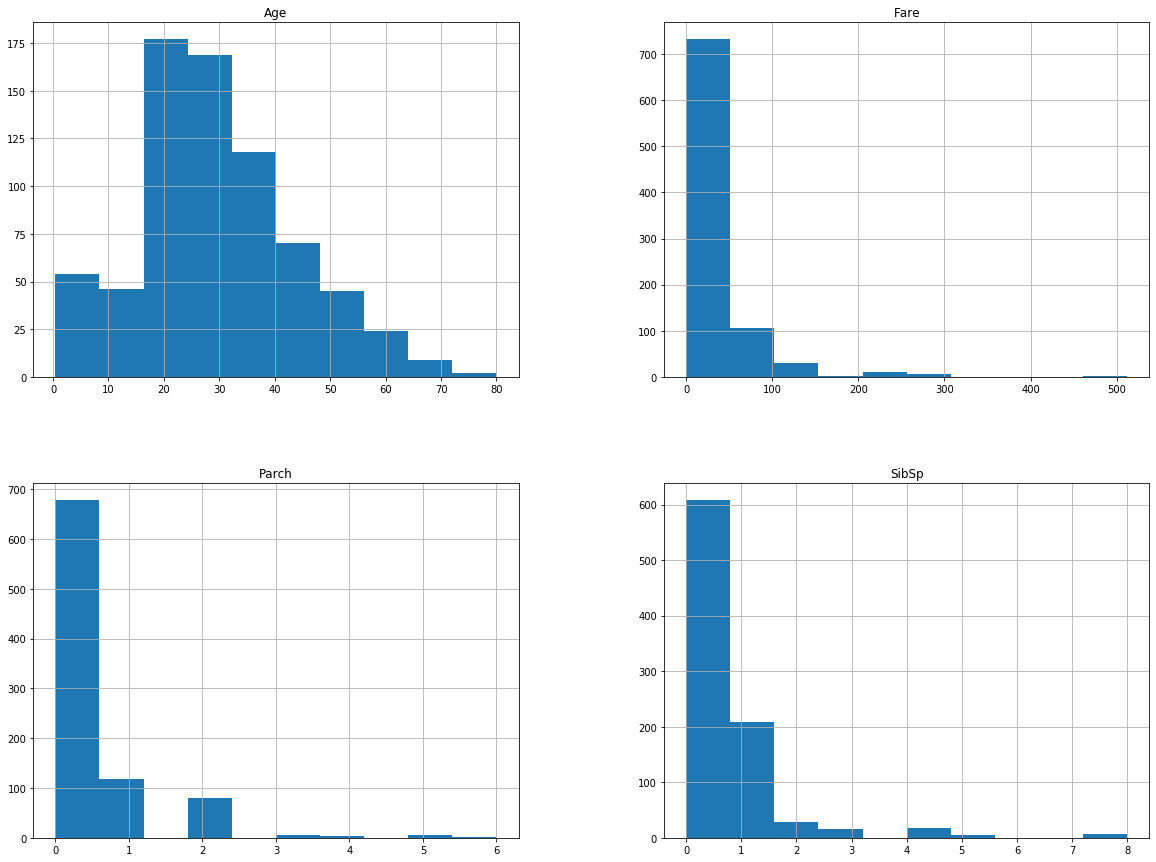

In [13]:
# Histograms of num data
data_num.hist(figsize=(20,15))
plt.show()

#### Comment:

Analysing above numerical data distributions we can see that only _Age_ attribute has a normal-ish distribution. For the rest of attributes it is necessary to modify them, e.g. using normalization.

        Age  SibSp  Parch  Fare
Age    1.00  -0.31  -0.19  0.10
SibSp -0.31   1.00   0.41  0.16
Parch -0.19   0.41   1.00  0.22
Fare   0.10   0.16   0.22  1.00


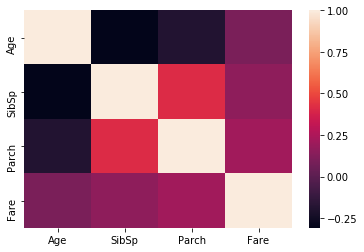

In [14]:
# Correlations
correlation = data_num.corr()
print(correlation)

sns.heatmap(correlation)

#### Comment:

There is rather weak correlation between numerical attributes. The strongest correlation occurs between _SibSp_ and _Parch_ , which concern number of family members on board for each passenger (observation).

In [15]:
# The average of num variables grouped by survival rate
pd.pivot_table(X_full, index='Survived', values=data_num.columns)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.63,22.12,0.33,0.55
1,28.34,48.40,0.46,0.47


#### - Categorical data:

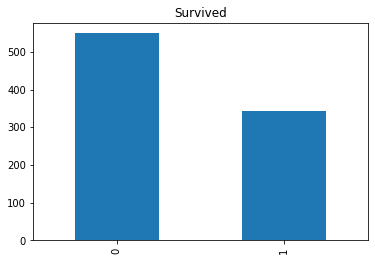

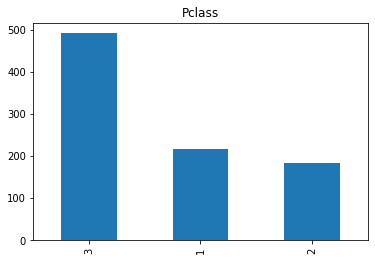

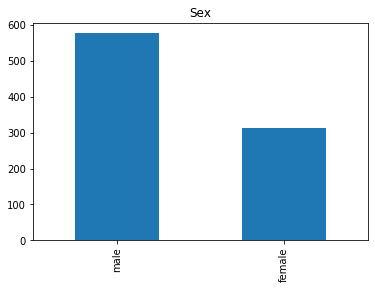

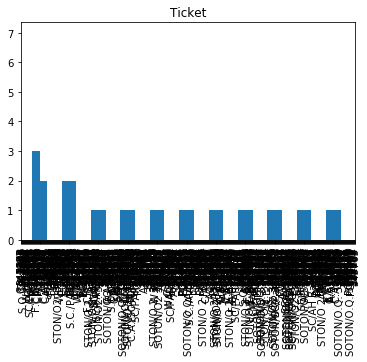

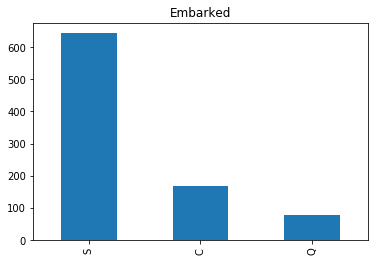

In [16]:
# The quantitive split for each categorical data value
for c in data_cat.columns:
    data_cat[c].value_counts().plot(kind="bar")
    plt.title(c)
    plt.show()

#### Comment:

Almost 2/3 of the passengers on board did not survive the crash. More than a half of them were travelling in Class 3. The vast majority were man who started their journey in the port of Southampton (S).

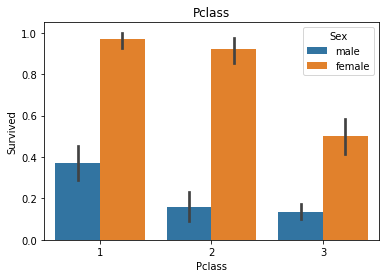

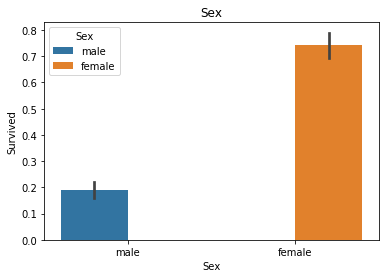

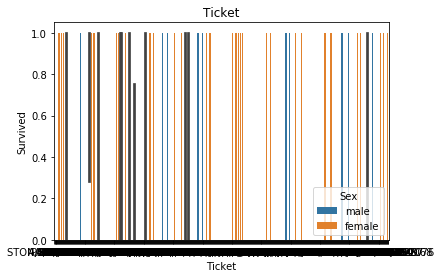

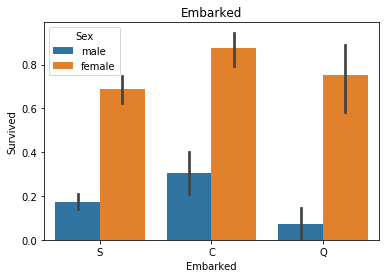

In [17]:
# Passenger survival depending on the values of cat. variables grouped by gender
for c in data_cat.columns[1:]:
    sns.barplot(x=c, y='Survived', hue='Sex', data=data_cat)
    plt.title(c)
    plt.show()

#### Comment:

It is clearly visible that the female gender is dominant group in passenger survival. The main reason is women (and children) were given a priority to leave the ship. At this moment, it can be assumed that _Sex_ attribute will have the biggest impact on the predictions regardless of the type of ML model. 

## 3. Feature Engineering & Data Cleaning

Training and test data preprocessing

In [18]:
# Replaces missing values in 'Age' and 'Embarked' columns:
for df in both_datasets:
    df['Age'] = df['Age'].fillna(df['Age'].median()) # replaces with median
    df['Fare'] = df['Fare'].fillna(df['Fare'].median()) # replaces with median
    df.dropna(subset=['Embarked'], how='any', inplace=True) # deletes 2 rows from training dataset (in test: 0)

In [19]:
# Creates feature 'Ticket_category' splitting tickets into 3 categories:
# - 0 - ticket symbol consists of letters only
# - 1 - ticket symbol consists of digits only
# - 2 - ticket symbol consists of both letters and digits

for df in both_datasets:
    df['Ticket_category'] = df['Ticket'].apply(
        lambda x: 1 if x.replace(' ', '').replace('.', '').replace('/', '').lower().isdigit() else 
        2 if x.replace(' ', '').replace('.', '').replace('/', '').lower().isalnum() else 0)

# Number of survivors depending on a ticket cat. (training dataset)
t_cat = pd.pivot_table(X_full, index='Survived', columns='Ticket_category', values='Ticket', aggfunc='count')
print(t_cat)

# Deletes useless 'Ticket' column
for df in both_datasets:
    df.drop(columns=['Ticket'], inplace=True) 

Ticket_category    1    2
Survived                 
0                407  142
1                252   88


In [20]:
# COUNT ENCODING

import category_encoders as ce

for df in both_datasets:
    # Extracts passenger title from 'Name' attribute
    df['Name_title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())


# Train data:
# 1. Creates Count Encoder
count_enc_train = ce.CountEncoder()
# 2. Creates new feature based on 'Name_title' and using Count Encoding 
count_encoded = count_enc_train.fit_transform(X_full['Name_title'])
# 3. Adds this new feature with '_count' suffix to DF
X_full = X_full.join(count_encoded.add_suffix("_count"))
# 4. Deletes useless columns: Name, Name_title
X_full.drop(columns=['Name', 'Name_title'], inplace=True)

# Test data:
# 1. Creates Count Encoder
count_enc_test = ce.CountEncoder()
# 2. Creates new feature based on 'Name_title' and using Count Encoding 
count_encoded = count_enc_test.fit_transform(X_test_full['Name_title'])
# 3. Adds this new feature with '_count' suffix to DF
X_test_full = X_test_full.join(count_encoded.add_suffix("_count"))
# 4. Deletes useless columns: Name, Name_title
X_test_full.drop(columns=['Name', 'Name_title'], inplace=True)

In [21]:
# ONE HOT ENCODING (OHE)
# OHE encodes values in the rest of cat. attributes ('Sex' and 'Embarked')

from sklearn.preprocessing import OneHotEncoder

# Train data:
# 1. Cat. attributes in dataset 
object_cols = [col for col in X_full.columns if X_full[col].dtype == "object"]
# 2. OHE for each cat. attribute
OH_encoder_train = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder_train.fit_transform(X_full[object_cols]))
# 3. Restores indexes removed by OHE operation
OH_cols_train.index = X_full.index
# 4. Adds new columns (created in OHE) to the dataset
X_full = pd.concat([X_full, OH_cols_train], axis=1)
# 5. Deletes useless cat. columns from datasets
X_full.drop(columns=object_cols, inplace=True)

# Test data:
# 1. Cat. attributes in dataset 
object_cols = [col for col in X_test_full.columns if X_test_full[col].dtype == "object"]
# 2. OHE for each cat. attribute
OH_encoder_test = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_test = pd.DataFrame(OH_encoder_test.fit_transform(X_test_full[object_cols]))
# 3. Restores indexes removed by OHE operation
OH_cols_test.index = X_test_full.index
# 4. Adds new columns (created in OHE) to the dataset
X_test_full = pd.concat([X_test_full, OH_cols_test], axis=1)
# 5. Deletes useless cat. columns from datasets
X_test_full.drop(columns=object_cols, inplace=True)

In [22]:
# NORMALIZATION
# Modifies 'Fare' attribute using normalization

for df in both_datasets:
    
    # Normalization
    df['Fare_normal'] = np.log(df['Fare'])
    
    # Deletes useless 'Fare' column
    df.drop(columns=['Fare'], inplace=True)

C:\Users\Maciek\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
# SCALLING
# Applied to features: Age, SibSp, Parch, Name_title_count

from sklearn.preprocessing import StandardScaler
    
# Train data:
# 1. Creates Scaler
scale_train = StandardScaler()
# 2. Scalling
X_full[['Age', 'SibSp', 'Parch', 'Name_title_count']] = scale_train.fit_transform(
    X_full[['Age', 'SibSp', 'Parch', 'Name_title_count']])

# Test data:
# 1. Creates Scaler
scale_test = StandardScaler()
# 2. Scalling
X_test_full[['Age', 'SibSp', 'Parch', 'Name_title_count']] = scale_test.fit_transform(
    X_test_full[['Age', 'SibSp', 'Parch', 'Name_title_count']])

In [24]:
X_full.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Ticket_category,Name_title_count,0,1,2,3,4
PassengerId,,,,,,,,,,,,,
1,0,3,-0.56,0.43,-0.47,7.25,2,0.83,0.0,1.0,0.0,0.0,1.0
2,1,1,0.67,0.43,-0.47,71.28,2,-1.21,1.0,0.0,1.0,0.0,0.0
3,1,3,-0.26,-0.48,-0.47,7.92,2,-0.91,1.0,0.0,0.0,0.0,1.0
4,1,1,0.44,0.43,-0.47,53.10,1,-1.21,1.0,0.0,0.0,0.0,1.0
5,0,3,0.44,-0.48,-0.47,8.05,1,0.83,0.0,1.0,0.0,0.0,1.0


In [25]:
X_test_full.head()

,Pclass,Age,SibSp,Parch,Fare,Ticket_category,Name_title_count,0,1,2,3,4
PassengerId,,,,,,,,,,,,
892,3,0.39,-0.50,-0.40,7.83,1,0.85,0.0,1.0,0.0,1.0,0.0
893,3,1.37,0.62,-0.40,7.00,1,-1.07,1.0,0.0,0.0,0.0,1.0
894,2,2.55,-0.50,-0.40,9.69,1,0.85,0.0,1.0,0.0,1.0,0.0
895,3,-0.20,-0.50,-0.40,8.66,1,0.85,0.0,1.0,0.0,0.0,1.0
896,3,-0.60,0.62,0.62,12.29,1,-1.07,1.0,0.0,0.0,0.0,1.0


## 4. Model building: K-Fold Cross Validation

Firstly, I evaluated 7 different classification models with default parameters. Next I choose the best one and tuned its parameters for better predictions.

In [26]:
# Prepares data for training
X_train = X_full.drop(columns=['Survived'])
y_train = X_full['Survived']

The Scikit-learn module performs data type conversion into 'float32' in the background. Sometimes it is a source of problems because it can convert data into infinite values which are treated by model as NaN. To avoid that kind of errors (ValueError) I decided to manually convert data into 'float32' type and next replaced all NaNs values with 0 (default setting) and all 'infinite' values with the largest finite floating point value for type 'float32':

In [27]:
X_train = np.nan_to_num(X_train.astype(np.float32))
y_train = np.nan_to_num(y_train.astype(np.float32))

In [28]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Models with default settings
model_1 = DecisionTreeClassifier(random_state=1)
model_2 = RandomForestClassifier(random_state=1)
model_3 = KNeighborsClassifier()
model_4 = SVC(probability=True)
model_5 = LogisticRegression(max_iter=1500)
model_6 = GaussianNB()
model_7 = XGBClassifier(random_state=1)

# K-Fold Cross Validation parameters
kf = KFold(n_splits=3, shuffle=True, random_state=1)

# Models' evaluation
cv_1 = cross_val_score(model_1, X_train, y_train, cv=kf)
cv_2 = cross_val_score(model_2, X_train, y_train, cv=kf)
cv_3 = cross_val_score(model_3, X_train, y_train, cv=kf)
cv_4 = cross_val_score(model_4, X_train, y_train, cv=kf)
cv_5 = cross_val_score(model_5, X_train, y_train, cv=kf)
cv_6 = cross_val_score(model_6, X_train, y_train, cv=kf)
cv_7 = cross_val_score(model_7, X_train, y_train, cv=kf)

print("Model_1: ", cv_1.mean())
print("Model_2: ", cv_2.mean())
print("Model_3: ", cv_3.mean())
print("Model_4: ", cv_4.mean())
print("Model_5: ", cv_5.mean())
print("Model_6: ", cv_6.mean())
print("Model_7: ", cv_7.mean())

C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarni

Model_1:  0.7975172141838809
Model_2:  0.8121416871416871
Model_3:  0.7862635362635363
Model_4:  0.811004186004186
Model_5:  0.8121265204598539
Model_6:  0.7851184517851184
Model_7:  0.8132678132678133


#### Comment:

From classification models with default parameters the highest quality of predictions has **_model_7_** working on **XGBoost** algorithm ( _Extreme Gradient Boosting_ ).

## 5. Parameters Tuning

An attempt to find hyperparameters that improve model quality (only the best model considered: model_7)

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
# possible hyperparameters
params = {"max_depth": [4, 5, 6],
          "learning_rate": [0.01, 0.05, 0.1],
          "n_estimators": [100, 500, 1000],
          "n_jobs": [-1]}

gridsearch_model_7 = GridSearchCV(model_7, param_grid=params, cv=kf, verbose=0)

# Looks for the best model (best params combination) using nested cross validation
quality_tuned_model_7 = cross_val_score(gridsearch_model_7, X_train, y_train).mean()
print(quality_tuned_model_7)

C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8279264112597446


#### Comment:

Using above grid of hyperparameters we found such combination of hyperparameters for XGBClassifier that raises model quality from 0.8133 to **0.8279**.

In [31]:
# Extracts params combination for the best model
best_model_7 = gridsearch_model_7.fit(X_train, y_train)
best_model_7.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

## 6. Test Dataset Prediction

In [32]:
# Copies of test dataset and gets rid of possible infinite or NaN values during 'sklearn' conversion into float32
test = X_test_full.copy()
test = np.nan_to_num(test.astype(np.float32))

# Predictions for test dataset
test_preds = best_model_7.predict(test).astype(int)

# Restores 'test' dataset to DF format
test = pd.DataFrame(test, index=X_test_full.index, columns=X_test_full.columns)

# Creates DF with test data and predictions
results = {'PassengerId': test.index, 'Survived': test_preds}
results = pd.DataFrame(data=results)
results.head(30)

# Creates DF with test data and predictions
results = test.copy()
results['Prediction'] = test_preds
results.head(5)

,Pclass,Age,SibSp,Parch,Fare,Ticket_category,Name_title_count,0,1,2,3,4,Prediction
PassengerId,,,,,,,,,,,,,
892,3.0,0.39,-0.50,-0.40,7.83,1.0,0.85,0.0,1.0,0.0,1.0,0.0,0
893,3.0,1.37,0.62,-0.40,7.00,1.0,-1.07,1.0,0.0,0.0,0.0,1.0,0
894,2.0,2.55,-0.50,-0.40,9.69,1.0,0.85,0.0,1.0,0.0,1.0,0.0,0
895,3.0,-0.20,-0.50,-0.40,8.66,1.0,0.85,0.0,1.0,0.0,0.0,1.0,0
896,3.0,-0.60,0.62,0.62,12.29,1.0,-1.07,1.0,0.0,0.0,0.0,1.0,1


## 7. Results Export

In [33]:
# Saves results into .csv file
save_res(results, 'test_prediction')

In [34]:
import sklearn
from sklearn.externals import joblib

# Scikit-learn version info
sklearn_version = sklearn.__version__

# Saves model into pickle
joblib.dump(best_model_7, './Results/best_model_{}.pkl'.format(sklearn_version))

C:\Users\Maciek\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['./Results/best_model_0.21.3.pkl']